In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import pickle

In [93]:


# Define basic sparse matrices (CSR format for efficient arithmetic)
sigma_z = sp.dia_matrix(([1, -1], 0), shape=(2, 2), dtype=complex).tocsr()
sigma_minus = sp.csr_matrix(([1], ([1], [0])), shape=(2, 2), dtype=complex)
identity = sp.eye(2, dtype=complex, format='csr')


def generate_sparse_fermionic_operators(N):
    """
    Generate sparse annihilation and creation operators for N orbitals with spin.
    
    Parameters:
    N (int): Number of orbitals.
    
    Returns:
    tuple: (annihilation_ops, creation_ops) where each is a list of 2N sparse matrices.
           The order is [orbital_0↑, orbital_0↓, orbital_1↑, orbital_1↓, ...].
    """
    
    total_modes = 2 * N
    annihilation_ops = []
    creation_ops = []
    
    for p in range(total_modes):
        # Initialize operator as a 1x1 identity matrix (to build Kronecker product)
        op = sp.eye(1, dtype=complex, format='csr')
        
        for q in range(total_modes):
            if q < p:
                term = sigma_z
            elif q == p:
                term = sigma_minus
            else:
                term = identity
            
            # Kronecker product with sparse matrices
            op = sp.kron(op, term, format='csr')
        
        annihilation_ops.append(op)
        creation_ops.append(op.conj().transpose())  # Hermitian adjoint
    
    return annihilation_ops, creation_ops

N = 8  # Number of orbitals
cs, cdags = generate_sparse_fermionic_operators(N)

In [104]:
import itertools

def get_m_basis_indices(N, M):
    """
    Generate the indices of the M-particle sector in the full Hilbert space.
    
    Parameters:
    N (int): Number of orbitals.
    M (int): Number of particles.
    
    Returns:
    list: Sorted list of indices in the full Hilbert space.
    """
    total_modes = 2 * N
    m_indices = []
    for bits in itertools.combinations(range(total_modes), M):
        index = 0
        for q in bits:
            # Reverse mode order to match the Kronecker product ordering
            pos = total_modes - 1 - q
            index += (1 << pos)
        m_indices.append(index)
    return sorted(m_indices)

# Example usage:
N = 8
M = 1  # Choose your desired particle number sector

# Generate the indices for the M-particle sector
m_indices = get_m_basis_indices(N, M)

# Assuming H is your Hamiltonian constructed as a sparse matrix in the full space
# Project H into the M-particle sector
#H_m = H[m_indices, :][:, m_indices]

# Convert to a dense matrix if needed (be cautious with memory)
# H_m_dense = H_m.toarray()

In [105]:
num_op = sp.csr_matrix((4**N, 4**N), dtype=complex)
for i in range(2*N):
    num_op+=cdags[i]@cs[i]

evals, evecs = sp.linalg.eigsh(num_op[m_indices, :][:, m_indices], return_eigenvectors=True, which='SM', k=10)
evals

array([15., 15., 15., 15., 15., 15., 15., 15., 15., 15.])

In [128]:
#Generate hamiltonian for 2x2x2 orbital Kane-Mele model

NN_list = np.array([(1,2), (2, 3), (3,4), (5, 6), (5, 8), (7, 8), (2, 5)]) - 1
NNN_list = np.array([(1, 3), (5, 7), (1, 5), (1, 7), (2, 8), (4, 6), (2, 4), (6, 8), (2, 6)]) - 1

a = np.array([[1, 0],[-1/2, np.sqrt(3)/2],[-1/2, -np.sqrt(3)/2]])*2
b = np.array([[0, np.sqrt(3)],[3/2, -np.sqrt(3)/2],[-3/2, -np.sqrt(3)/2]])


def g(k):
    return np.sum(np.exp(1j*a@k))

def g_bar(k):
    return np.sum(np.exp(1j*b@k))

def hamil(t, mu, U, l_so, phi_h, k):
    hamiltonian = sp.csr_matrix((4**N, 4**N), dtype=complex)
    g_k = g(k)
    g_bar_k = g_bar(k)
    for NN in NN_list:
        hamiltonian+=(cdags[NN[0]*2]@cs[NN[1]*2]*g_k + cdags[NN[1]*2]@cs[NN[0]*2]*np.conj(g_k))*t*-1/2
        hamiltonian+=(cdags[NN[0]*2+1]@cs[NN[1]*2+1]*g_k + cdags[NN[1]*2+1]@cs[NN[0]*2+1]*np.conj(g_k))*t*-1/2
    for NNN in NNN_list:
        hamiltonian+=(cdags[NNN[0]*2]@cs[NNN[1]*2] + cdags[NNN[1]*2]@cs[NNN[0]])*l_so*(np.cos(phi_h)*np.real(g_bar_k)-np.imag(g_bar_k)*np.sin(phi_h))
        hamiltonian+=(cdags[NNN[0]*2+1]@cs[NNN[1]*2+1] + cdags[NNN[1]*2+1]@cs[NNN[0]*2+1])*l_so*(np.cos(phi_h)*np.real(g_bar_k)-np.imag(g_bar_k)*np.sin(phi_h))
    for i in range(N):
        hamiltonian+=cdags[i*2]@cs[i*2]@cdags[i*2+1]@cs[i*2+1]*U
        hamiltonian+=-mu*(cdags[i*2]@cs[i*2]+cdags[i*2+1]@cs[i*2+1])
    
    return hamiltonian

In [29]:
k=np.array([0, 1])
a@k

array([ 0.       ,  0.8660254, -0.8660254])

In [6]:
#Generate hamiltonian for 2x1x1 orbital Kane-Mele model

NN_list = np.array([(1,2)]) - 1
#NNN_list = np.array([(1, 3), (5, 7), (1, 5), (1, 7), (2, 8), (4, 6), (2, 4), (6, 8), (2, 6)]) - 1



def hamil_2orb(t, mu, U, l_so, phi_h, k):
    hamiltonian = sp.csr_matrix((4**N, 4**N), dtype=complex)
    g_k = g(k)
    g_bar_k = g_bar(k)
    for NN in NN_list:
        hamiltonian+=(cdags[NN[0]*2]@cs[NN[1]*2]*g_k + cdags[NN[1]*2]@cs[NN[0]*2]*np.conj(g_k))*t*-1/2
        hamiltonian+=(cdags[NN[0]*2+1]@cs[NN[1]*2+1]*g_k + cdags[NN[1]*2+1]@cs[NN[0]*2+1]*np.conj(g_k))*t*-1/2
    
    return hamiltonian

In [7]:
test_hamil = hamil_2orb(1, 5, 10, 0.3, np.pi/2, (np.pi,np.pi))#[m_indices, :][:, m_indices]

In [26]:
#test_hamil.toarray()

In [9]:
evals, evecs = sp.linalg.eigsh(test_hamil, return_eigenvectors=True, which='SM')

In [10]:
cutoff = np.sum(np.abs((evals-evals[0]))<1e-10)

In [27]:
#evecs[:,:cutoff]

In [129]:
t = 1
U = 0
mu = 0
l_so = 0#0.3
k_num = 20
phi_h = 0#0.81*np.pi

n_evals = 10

k_range = (np.arange(k_num)-k_num/2)/k_num

kx_range = np.array([[-1/2, np.sqrt(3)/2]]*k_num)*4*np.pi/np.sqrt(3)*k_range[:, np.newaxis]
ky_range = np.array([[1/2, np.sqrt(3)/2]]*k_num)*4*np.pi/np.sqrt(3)*k_range[:, np.newaxis]

energies = np.zeros(shape=(k_num, k_num, n_evals))

occ_sum = 0
acc = 1
for i, kx in enumerate(kx_range):
    for j, ky in enumerate(ky_range):
        k = kx+ky
        #print(i, j)
        hamil_k = hamil(t, mu, U, l_so, phi_h, k)[m_indices, :][:, m_indices]
        #hamil_k = hamil_2orb(t, mu, U, l_so, phi_h, k).toarray()
        evals = sp.linalg.eigsh(hamil_k, return_eigenvectors=False, which='SR', k=n_evals)
        #evals = np.linalg.eigvals(hamil_k)
        energies[i,j,:] = evals
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


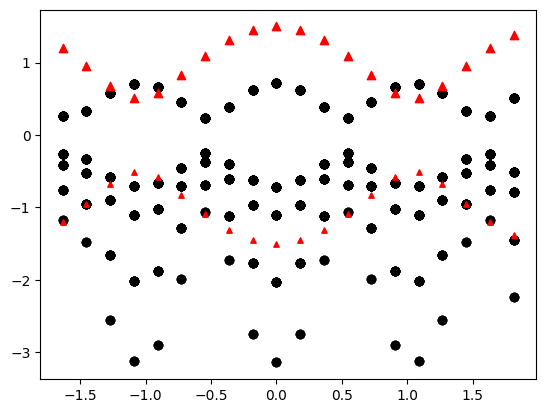

In [130]:
x_vals, y_vals = [],[]
y_ind = 10

for index in range(n_evals):
    for i, kx in enumerate(kx_range):
        k = kx+ky_range[y_ind]
        x_vals.append(k[0])  # Directly use kx for x-axis
        y_vals.append(energies[i,y_ind,index])

        
    plt.scatter(x_vals, y_vals, c='k')

x_vals, y_vals, y_vals_2 = [],[], []
for i, kx in enumerate(kx_range):
    k = kx+ky_range[y_ind]
    x_vals.append(k[0])  # Directly use kx for x-axis
    exact_hamil = np.array([[0,g(k/2)],[np.conj(g(k/2)), 0]])/2
    
    y_vals.append(np.linalg.eigvals(exact_hamil)[0])
    y_vals_2.append(np.linalg.eigvals(exact_hamil)[1])
plt.scatter(x_vals, y_vals, c='red', marker='^')
plt.scatter(x_vals, y_vals_2, c='red', marker='^', s=15)

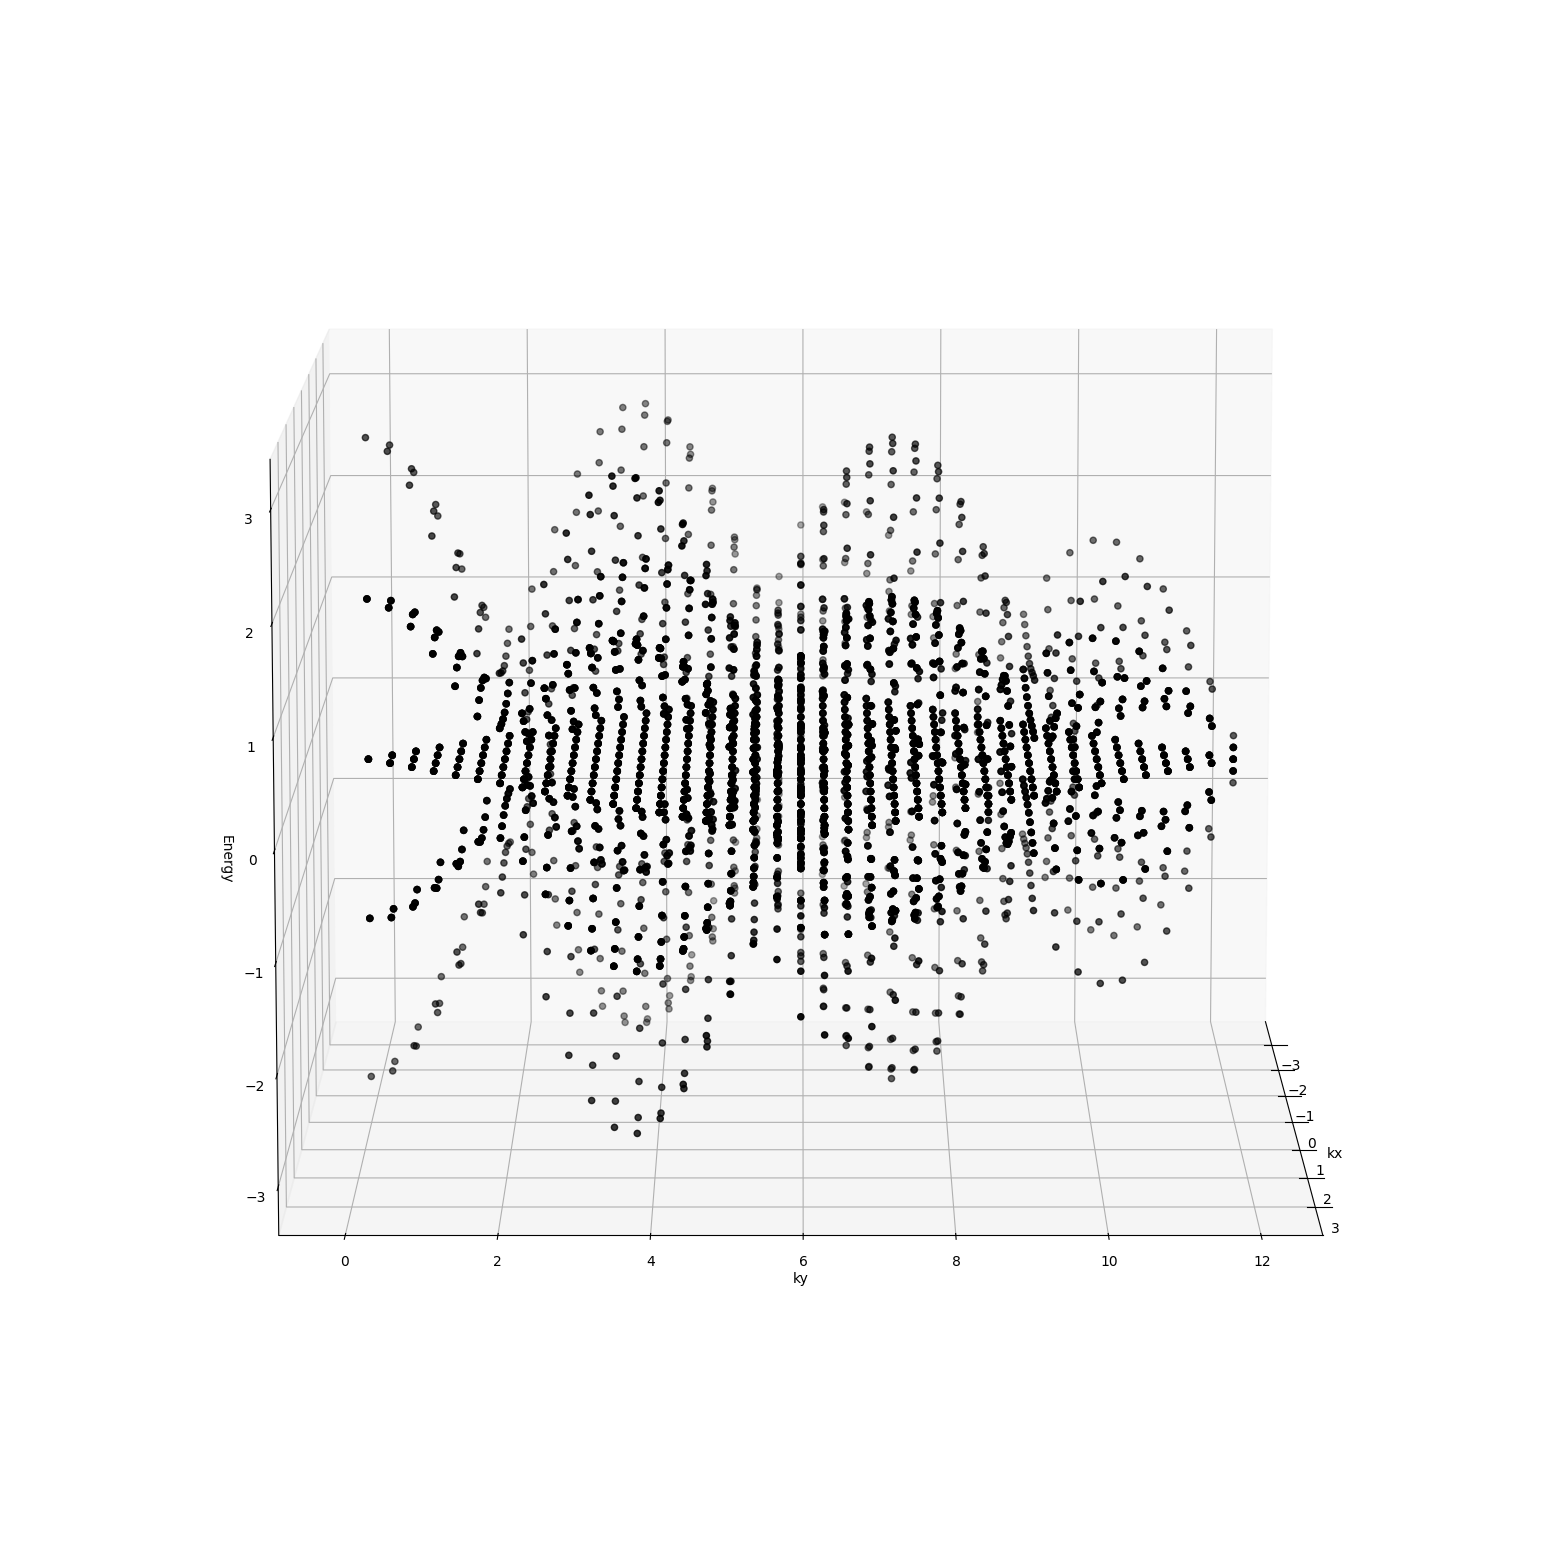

In [25]:

import matplotlib.pyplot as plt

# Assuming kx_range and ky_range are defined (e.g., numpy arrays or lists)
# Example definitions (replace with your actual data):
# import numpy as np
# kx_range = np.linspace(-1, 1, 10)
# ky_range = np.linspace(-1, 1, 10)
# n_evals = 3  # Define based on your energies array shape

x_vals = []
y_vals = []
z_vals = []

for index in range(n_evals):
    for i, kx in enumerate(kx_range):
        for j, ky in enumerate(ky_range):
            k = kx+ky
            x_vals.append(k[0])  # Directly use kx for x-axis
            y_vals.append(k[1])  # Directly use ky for y-axis
            z_vals.append(energies[i, j, index])

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')  # Correct 3D axis creation

ax.scatter(x_vals, y_vals, z_vals, c='k')  # 's' controls marker size
ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('Energy')

ax.view_init(elev=10, azim=0)

plt.show()

In [17]:
!pip install jupyter-matplotlib

ERROR: Could not find a version that satisfies the requirement jupyter-matplotlib (from versions: none)
ERROR: No matching distribution found for jupyter-matplotlib


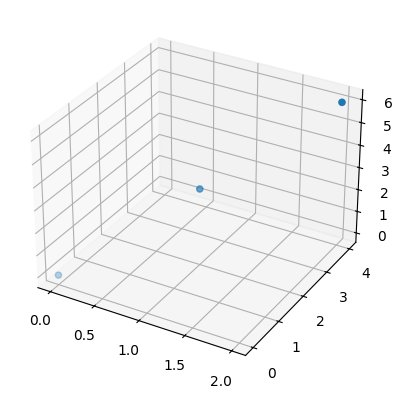

In [175]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter([0,1,2], [0,2,4], [0,3,6])

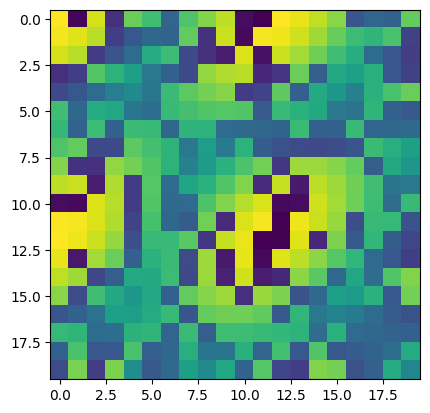

In [157]:
plt.imshow(energies[:,:,7])

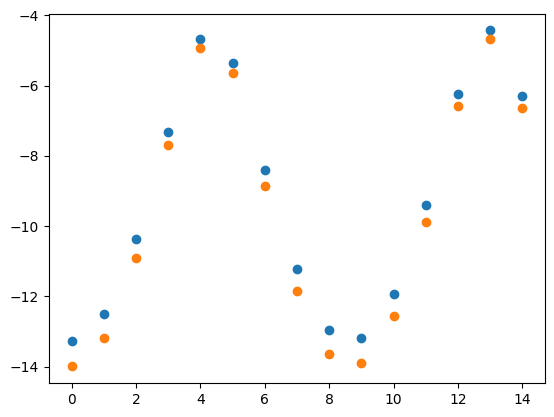

In [88]:
for index in range(n_evals):
    x_vals = []
    y_vals = []
    for i, kx in enumerate(kx_range):
        x_vals.append(i)
        y_vals.append(energies[i,i,index])
    plt.scatter(x_vals, y_vals)
        

In [13]:
def get_occupancy(t, U, mu, l_so, phi_h, k_num):
    
    k_range = np.arange(k_num)/k_num

    kx_range = np.array([[-1/2, np.sqrt(3)/2]]*k_num)*4*np.pi/np.sqrt(3)*k_range[:, np.newaxis]
    ky_range = np.array([[1/2, np.sqrt(3)/2]]*k_num)*4*np.pi/np.sqrt(3)*k_range[:, np.newaxis]
    
    occ_sum = 0
    acc = 1
    for kx in kx_range:
        for ky in ky_range:
            #print(str(acc)+"/"+str(k_num**2)); acc+=1;
            k = kx+ky
            hamil_k = hamil(t, mu, U, l_so, phi_h, k)
            evals, evecs = sp.linalg.eigsh(hamil_k, return_eigenvectors=True, which='SR', k=4)
            cutoff = np.sum(np.abs((evals-evals[0]))<1e-10)
            if cutoff>1: print(cutoff)
            gs_vecs = evecs[:,:cutoff]
            for i in range(2*N):
                occ_sum += (gs_vecs.conj().T@cdags[i]@cs[i]@gs_vecs).sum()/cutoff 
    
    return occ_sum/(k_num**2)/(2*N)

In [16]:
t = 1
U = 0
mu = U/2+1
l_so = 0.3
k_num = 10
phi_h = 0.81*np.pi

mu_range = np.linspace(-2*t, 2*t, 30)
occ_array = np.zeros_like(mu_range)

for ind, mu in enumerate(mu_range):
    print(ind, len(mu_range)-1)
    occ_array[ind] = get_occupancy(t, U, mu, l_so, phi_h, k_num)

0 29


KeyboardInterrupt: 

In [12]:
data_dict = {'mu':mu_range, 'occ':occ_array}

Text(0, 0.5, '$n_{occ}$ (Occupancy)')

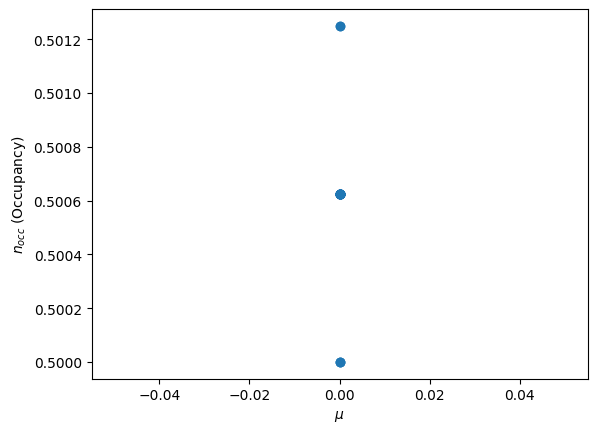

In [13]:
with open('trivial.pkl', 'rb') as handle:
    data_dict = pickle.load(handle)

plt.scatter(data_dict['mu'], data_dict['occ'])
plt.xlabel(r"$\mu$")
plt.ylabel(r"$n_{occ}$ (Occupancy)")

In [14]:
occ_array

array([0.500625, 0.500625, 0.500625, 0.500625, 0.500625, 0.500625,
       0.5     , 0.500625, 0.500625, 0.500625, 0.50125 , 0.500625,
       0.500625, 0.500625, 0.500625, 0.500625, 0.5     , 0.500625,
       0.500625, 0.500625, 0.500625, 0.500625, 0.500625, 0.5     ,
       0.500625, 0.500625, 0.500625, 0.500625, 0.500625, 0.50125 ])

In [17]:
occ_array
lambda_so = 0.3
phi = 0.81*np.pi


array([0.03757812, 0.04359375, 0.05625   , 0.06242188, 0.0646875 ,
       0.074375  , 0.08851562, 0.12242187, 0.14007813, 0.17390625,
       0.20046875, 0.2125    , 0.23454096, 0.25007812, 0.27700859,
       0.32156429, 0.37500572, 0.37499156, 0.39701204, 0.41598055,
       0.48148438, 0.48523438, 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ])

In [86]:
k_num = 15

k_range = (np.arange(k_num)-k_num/2)/k_num

kx_range = np.array([[-1/2, np.sqrt(3)/2]]*k_num)*4*np.pi/np.sqrt(3)*k_range[:, np.newaxis]
ky_range = np.array([[1/2, np.sqrt(3)/2]]*k_num)*4*np.pi/np.sqrt(3)*k_range[:, np.newaxis]

(-7.0, 7.0)

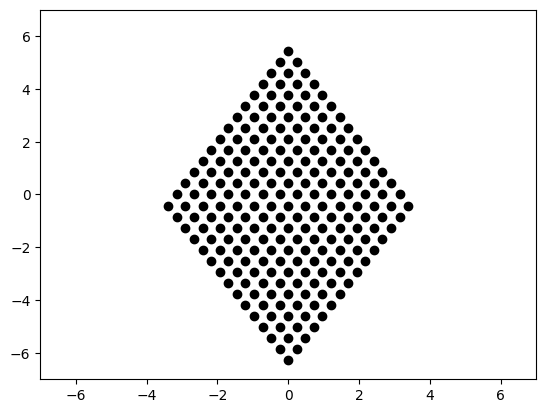

In [87]:

for i, kx in enumerate(kx_range):
    for j, ky in enumerate(ky_range):
        k = kx+ky
        #print(k[0], k[1])
        plt.scatter([k[0]], [k[1]], c='k')
        
plt.xlim(-7, 7)
plt.ylim(-7, 7)

In [59]:
kx_range

array([[-0.        ,  0.        ],
       [-0.18137994,  0.31415927],
       [-0.36275987,  0.62831853],
       [-0.54413981,  0.9424778 ],
       [-0.72551975,  1.25663706],
       [-0.90689968,  1.57079633],
       [-1.08827962,  1.88495559],
       [-1.26965955,  2.19911486],
       [-1.45103949,  2.51327412],
       [-1.63241943,  2.82743339],
       [-1.81379936,  3.14159265],
       [-1.9951793 ,  3.45575192],
       [-2.17655924,  3.76991118],
       [-2.35793917,  4.08407045],
       [-2.53931911,  4.39822972],
       [-2.72069905,  4.71238898],
       [-2.90207898,  5.02654825],
       [-3.08345892,  5.34070751],
       [-3.26483886,  5.65486678],
       [-3.44621879,  5.96902604]])